In [46]:
import numpy as np
import torch
import deeplay as dl
import torchvision
import PIL
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import sklearn 
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import os



In [7]:

def read_mnist_txt(file_path):
    """Read MNIST-like data from text file"""
    images = []
    labels = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if not line.strip():
                continue
            parts = line.strip().split()
            image_num = parts[0].strip('"')
            label = int(parts[1])
            
            # Validate label range
            if label < -9 or label > 9:
                raise ValueError(f"Invalid label {label} found in the dataset.")
            
            pixels = list(map(float, parts[2:]))
            pixel_array = np.array(pixels).reshape(16, 16)
            images.append(pixel_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [8]:

class MNISTDataset(Dataset):
    """Custom Dataset for MNIST-like data"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert to PIL Image for compatibility with torchvision transforms
        image = Image.fromarray(image.astype('float32'))
        
        if self.transform:
            image = self.transform(image)
        
        # Shift labels to zero-based indexing
        label = torch.tensor(label + 9, dtype=torch.long)
        
        return image, label

def create_cnn_model():
    """Create CNN model using deeplay"""
    conv_base = dl.ConvolutionalNeuralNetwork(
        in_channels=1, 
        hidden_channels=[16, 16, 32], 
        out_channels=32,
    )
    conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

    connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

    # Update out_features to 19 for labels -9 to 9
    dense_top = dl.MultiLayerPerceptron(
        in_features=32,
        hidden_features=[64],
        out_features=19,  # Updated
        out_activation=torch.nn.LogSoftmax(dim=1)
    )

    return dl.Sequential(conv_base, connector, dense_top)

def train_cnn(train_images, train_labels,lr, epochs=20):
    """Train the CNN model and return the trained classifier."""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create dataset and dataloader
    train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # Create model
    cnn = create_cnn_model()

    # Define classifier
    class MNISTClassifier(dl.Classifier):
        def __init__(self, model, optimizer):
            super().__init__(model=model, optimizer=optimizer)
            self.loss_fn = torch.nn.NLLLoss()
        
        def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.model(x)
            loss = self.loss_fn(y_hat, y)
            return loss

    classifier = MNISTClassifier(
        model=cnn,
        optimizer=dl.RMSprop(lr)
    ).create()

    # Train the model
    trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
    trainer.fit(classifier, train_loader)

    return classifier


# Prediction function
def predict_with__cnn(classifier, test_images):
    """Use trained classifier to make predictions on test_images."""
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Dummy labels for test set
    test_dataset = MNISTDataset(test_images, np.zeros(len(test_images)), transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Get predictions
    test_labels = []
    classifier.eval()
    with torch.no_grad():
        for x, _ in test_loader:
            y_hat = classifier.model(x)
            preds = torch.argmax(y_hat, dim=1)
            test_labels.extend((preds - 9).cpu().numpy().tolist())  # Adjust if needed

    return test_labels


# Main execution
if __name__ == "__main__":
    images, labels = read_mnist_txt("Numbers.txt")

    train_images, test_images, train_labels, _ = train_test_split(
        images, labels, test_size=0.2, random_state=42
    )

    classifier = train_cnn(train_images, train_labels)
    predictions = predict_with__cnn(classifier, test_images)

    print("First 10 test predictions:", predictions[:10])

NameError: name 'Dataset' is not defined

In [59]:
#modified PCA to work with cross-validator
def dataPrep(images, labels, test_size=200):
    """Prepare and split data into train/test sets"""
    randomIndices = np.random.permutation(len(images))
    images = np.array(images)[randomIndices]
    labels = np.array(labels)[randomIndices]

    trainingSet = images[:len(images)-test_size]
    trainingLabels = labels[:len(images)-test_size]
    testSet = images[-test_size:]
    testSetLabels = labels[-test_size:]
    
    print('Shape of training set:', trainingSet.shape)
    print('Shape of test set:', testSet.shape)
    
    return trainingSet, trainingLabels, testSet, testSetLabels

# Only these 2 functions need to change:

def dimRedPCA(trainingSet, testSet=None, trainVariance=.95):
    """Modified to consistently return (data, pca) or (train_data, test_data, pca)"""
    xTrain = trainingSet.reshape(len(trainingSet), -1)
    pca = PCA(n_components=trainVariance)
    trainPCA = pca.fit_transform(xTrain)
    
    if testSet is None:
        return trainPCA, pca  # Return PCA object when no test set
    else:
        xTest = testSet.reshape(len(testSet), -1)
        return trainPCA, pca.transform(xTest), pca

def train_PCA(train_images, train_labels, max_iter=5000):
    """Training function that handles PCA"""
    train_flat = train_images.reshape(len(train_images), -1)
    train_pca, pca = dimRedPCA(train_flat)  # Now correctly unpacks 2 values
    
    clf = MLPClassifier(solver='sgd', activation='logistic', max_iter = max_iter)
    clf.fit(train_pca, train_labels)
    return clf, pca  # Return both classifier and PCA object

def predict_with_PCA(model_tuple, test_images):
    """Prediction function that applies PCA"""
    clf, pca = model_tuple
    test_flat = test_images.reshape(len(test_images), -1)
    test_pca = pca.transform(test_flat)
    return clf.predict(test_pca)

def logisticNNPCA(filePath='Numbers.txt', trainVariance=.95):
    """Original pipeline function"""
    images, labels = read_mnist_txt(filePath)
    trainingSet, trainingLabels, testSet, testSetLabels = dataPrep(images, labels)
    trainPCA, testPCA = dimRedPCA(trainingSet, testSet, trainVariance)
    
    model = train_PCA(trainPCA, trainingLabels)
    predictedLabels = predict_with_PCA(model, testPCA, testSetLabels)
    
    print(predictedLabels)
    return predictedLabels

In [33]:
#random forest for cross-validation
from sklearn.metrics import accuracy_score

def train_RandomForest(trainingSet, trainingLabels, n_estimators=100):
    """Train Random Forest classifier and return the trained model"""
    # Flatten images to 1D arrays
    X_train = [img.flatten() for img in trainingSet]
    
    # Initialize and train Random Forest
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, trainingLabels)
    
    return rf

def predict_with_RandomForest(model, testSet):
    """Make predictions using trained Random Forest model"""
    # Flatten test images to 1D arrays
    X_test = [img.flatten() for img in testSet]
    
    # Return predictions
    return model.predict(X_test)

def randomForestClassifier(trainingSet, trainingLabels, testSet, n_estimators=100):
    """Original function maintained for backward compatibility"""
    rf = train_RandomForest(trainingSet, trainingLabels, n_estimators)
    return predict_with_RandomForest(rf, testSet)

In [4]:
# "Training" function for k-NN (just returns training data and labels)
def train_knn_model(train_images, train_labels, k=3, norm=2):
    return {
        'train_images': train_images,
        'train_labels': train_labels,
        'k': k,
        'norm': norm
    }

# Prediction function for k-NN
def predict_knn(model, test_images):
    train_images = model['train_images']
    train_labels = model['train_labels']
    k = model['k']
    norm = model['norm']
    
    predictions = []
    for image in test_images:
        distances = [(
            np.linalg.norm(train_image - image, ord=norm), label
        ) for train_image, label in zip(train_images, train_labels)]
        
        neighbors = sorted(distances, key=lambda x: x[0])[:k]
        labels = [label for _, label in neighbors]
        predicted = max(labels, key=labels.count)
        predictions.append(predicted)
    
    return predictions


In [44]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_validate(images, labels, train_fn, predict_fn, k_folds=5, metric_fn=accuracy_score):
    """
    Generic cross-validation.

    Args:
        images (np.ndarray): Image data.
        labels (np.ndarray): Corresponding labels.
        train_fn (callable): Function to train a model. Signature: (train_images, train_labels) -> model
        predict_fn (callable): Function to predict. Signature: (model, test_images) -> predictions
        k_folds (int): Number of folds (default 5).
        metric_fn (callable): Evaluation metric function. Signature: (true_labels, predicted_labels) -> float

    Returns:
        List of scores for each fold.
    """
    all_scores = []
    kf = KFold(n_splits=k_folds, shuffle=True, )#random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(images)):
        print(f"\nFold {fold + 1}/{k_folds}")

        train_images, val_images = images[train_idx], images[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Train and predict
        model = train_fn(train_images, train_labels)
        predictions = predict_fn(model, val_images)

        # Score
        score = metric_fn(val_labels, predictions)
        print(f"Fold {fold + 1} Score: {score:.4f}")
        all_scores.append(score)

    print("\nCross-validation results:")
    print(f"Mean score: {np.mean(all_scores):.4f}")
    print(f"Std deviation: {np.std(all_scores):.4f}")

    return all_scores


Testing n_estimators = 5
  Repeat 1/3
    Accuracy: 0.8550  =>  Error: 0.1450
  Repeat 2/3
    Accuracy: 0.8575  =>  Error: 0.1425
  Repeat 3/3
    Accuracy: 0.8125  =>  Error: 0.1875
Testing n_estimators = 10
  Repeat 1/3
    Accuracy: 0.8925  =>  Error: 0.1075
  Repeat 2/3
    Accuracy: 0.8925  =>  Error: 0.1075
  Repeat 3/3
    Accuracy: 0.8775  =>  Error: 0.1225
Testing n_estimators = 20
  Repeat 1/3
    Accuracy: 0.9125  =>  Error: 0.0875
  Repeat 2/3
    Accuracy: 0.9100  =>  Error: 0.0900
  Repeat 3/3
    Accuracy: 0.9125  =>  Error: 0.0875
Testing n_estimators = 50
  Repeat 1/3
    Accuracy: 0.9250  =>  Error: 0.0750
  Repeat 2/3
    Accuracy: 0.9300  =>  Error: 0.0700
  Repeat 3/3
    Accuracy: 0.9300  =>  Error: 0.0700
Testing n_estimators = 100
  Repeat 1/3
    Accuracy: 0.9250  =>  Error: 0.0750
  Repeat 2/3
    Accuracy: 0.9250  =>  Error: 0.0750
  Repeat 3/3
    Accuracy: 0.9425  =>  Error: 0.0575
Testing n_estimators = 150
  Repeat 1/3
    Accuracy: 0.9200  =>  Error: 0.

C:\Users\Nils\AppData\Local\Temp\ipykernel_24980\1701069328.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_by_estimators, labels=[str(n) for n in estimator_values], patch_artist=True)


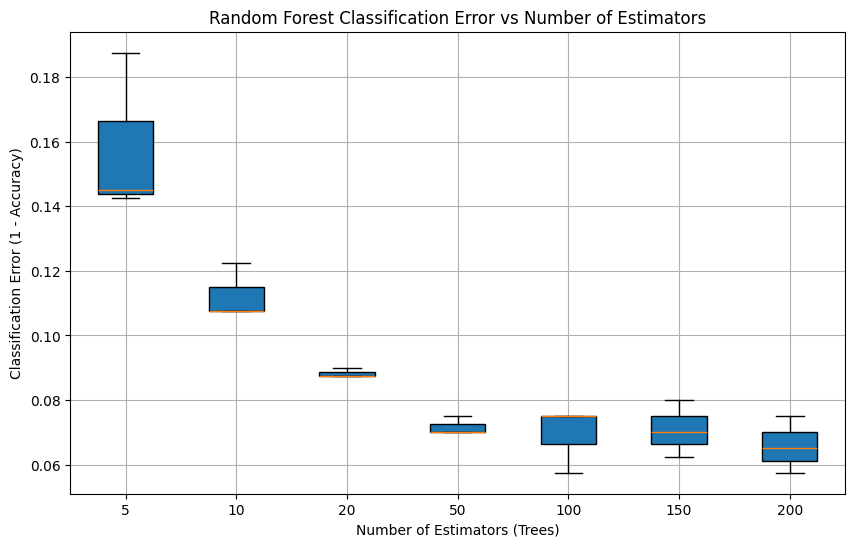


n_estimators = 5, Sorted Errors (3 values):
[0.14249999999999996, 0.14500000000000002, 0.1875]

n_estimators = 10, Sorted Errors (3 values):
[0.10750000000000004, 0.10750000000000004, 0.12250000000000005]

n_estimators = 20, Sorted Errors (3 values):
[0.08750000000000002, 0.08750000000000002, 0.08999999999999997]

n_estimators = 50, Sorted Errors (3 values):
[0.06999999999999995, 0.06999999999999995, 0.07499999999999996]

n_estimators = 100, Sorted Errors (3 values):
[0.057499999999999996, 0.07499999999999996, 0.07499999999999996]

n_estimators = 150, Sorted Errors (3 values):
[0.0625, 0.06999999999999995, 0.07999999999999996]

n_estimators = 200, Sorted Errors (3 values):
[0.057499999999999996, 0.06499999999999995, 0.07499999999999996]


In [57]:
#tune random forest with Cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# Define estimator values to test
estimator_values = [5, 10, 20, 50, 100, 150, 200]
repeats = 3
errors_by_estimators = []

# Load and flatten images
images, labels = read_mnist_txt("Numbers.txt")
images = images.reshape(len(images), -1)  # Flatten for Random Forest
images = StandardScaler().fit_transform(images)

for n in estimator_values:
    print(f"Testing n_estimators = {n}")
    error_list = []

    for repeat in range(repeats):
        print(f"  Repeat {repeat + 1}/{repeats}")
        
        X_train, X_test, y_train, y_test = train_test_split(
            images, labels, test_size=0.2, random_state=42 + repeat
        )

        # Train and evaluate Random Forest
        rf = RandomForestClassifier(n_estimators=n, random_state=42)
        rf.fit(X_train, y_train)
        predictions = rf.predict(X_test)

        acc = accuracy_score(y_test, predictions)
        error = 1 - acc
        print(f"    Accuracy: {acc:.4f}  =>  Error: {error:.4f}")
        error_list.append(error)

    errors_by_estimators.append(error_list)

# Plotting error vs n_estimators
plt.figure(figsize=(10, 6))
plt.boxplot(errors_by_estimators, labels=[str(n) for n in estimator_values], patch_artist=True)
plt.title("Random Forest Classification Error vs Number of Estimators")
plt.xlabel("Number of Estimators (Trees)")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True)
plt.show()

# Print sorted errors
for i, n in enumerate(estimator_values):
    sorted_errors = sorted(errors_by_estimators[i])
    print(f"\nn_estimators = {n}, Sorted Errors ({len(sorted_errors)} values):")
    print(sorted_errors)


In [5]:
#tune knn with CV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from functools import partial

if __name__ == "__main__":
    # Load and preprocess
    images, labels = read_mnist_txt("Numbers.txt")
    flat_images = images.reshape(len(images), -1)
    flat_images = StandardScaler().fit_transform(flat_images)

    # k values to test
    k_values = [1, 3, 5, 7, 10, 15, 25, 40]
    repeats = 8
    all_results = []

    print("Starting cross-validation...\n")

    for k in k_values:
        print(f"Testing k = {k}")
        scores_k = []
        train_fn = partial(train_knn_model, k=k, norm=2)

        for rep in range(repeats):
            print(f"  Repeat {rep + 1}/{repeats}")
            scores = cross_validate(
                images=flat_images,
                labels=labels,
                train_fn=train_fn,
                predict_fn=predict_knn,
                k_folds=5,
                metric_fn=accuracy_score
            )
            scores_k.extend(scores)

        all_results.append(scores_k)

    # Compute mean classification error for each k
knn_mean_errors = [1 - np.mean(scores) for scores in all_results]

plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_mean_errors, marker='o', linestyle='-', color='purple')
plt.title("Mean Classification Error vs. k (k-NN)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()

for i, k in enumerate(k_values):
    sorted_scores = sorted(all_results[i])
    print(f"\nk = {k}, Sorted Accuracy Scores ({len(sorted_scores)} values):")
    print(sorted_scores)


NameError: name 'read_mnist_txt' is not defined

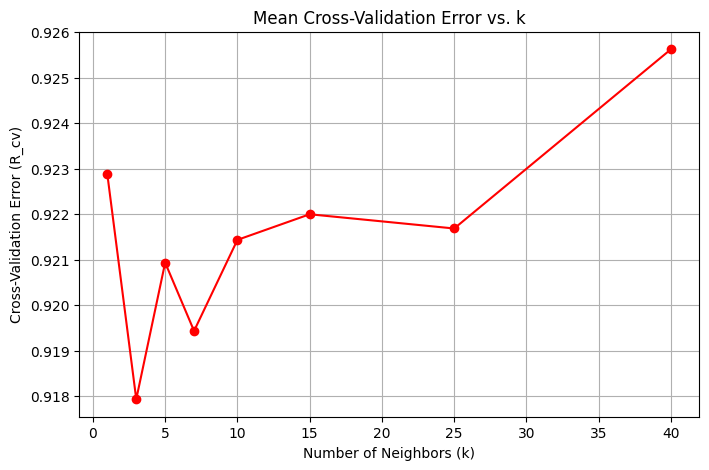

In [52]:
# Compute mean cross-validation error for each k
mean_errors = [1 - np.mean(scores_k) for scores_k in all_results]

# Plot k vs. R_cv(k)
plt.figure(figsize=(8, 5))
plt.plot(k_values, mean_errors, marker='o', linestyle='-', color='red')
plt.title("Mean Cross-Validation Error vs. k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Cross-Validation Error (R_cv)")
plt.grid(True)
plt.show()


In [6]:
# Compute mean classification error for each k
knn_mean_errors = [1 - np.mean(scores) for scores in all_results]

plt.figure(figsize=(8, 5))
plt.plot(k_values, knn_mean_errors, marker='o', linestyle='-', color='purple')
plt.title("Mean Classification Error vs. k (k-NN)")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()


NameError: name 'all_results' is not defined

In [32]:
#perform PCA classification with cross-validation
if __name__ == "__main__":
    images, labels = read_mnist_txt("Numbers.txt")

    scores = cross_validate(
        images=images,
        labels=labels,
        train_fn=train_PCA,
        predict_fn=predict_with_PCA,
        k_folds=5,
        metric_fn=accuracy_score  # Optional, default already
    )



Fold 1/5
Fold 1 Score: 0.9075

Fold 2/5
Fold 2 Score: 0.9300

Fold 3/5
Fold 3 Score: 0.9150

Fold 4/5
Fold 4 Score: 0.9525

Fold 5/5
Fold 5 Score: 0.9225

Cross-validation results:
Mean score: 0.9255
Std deviation: 0.0154


Starting cross-validation...

Testing max_iter = 100
  Repeat 1/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8600

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8025

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.8025

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8250

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.7825

Cross-validation results:
Mean score: 0.8145
Std deviation: 0.0264
  Repeat 2/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8300

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8100

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.7975

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.7850

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.8275

Cross-validation results:
Mean score: 0.8100
Std deviation: 0.0172
  Repeat 3/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.7875

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.7925

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.8125

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8300

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.8100

Cross-validation results:
Mean score: 0.8065
Std deviation: 0.0152
  Repeat 4/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.7875

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8100

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.8225

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8050

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.8150

Cross-validation results:
Mean score: 0.8080
Std deviation: 0.0118
  Repeat 5/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.7925

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8225

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.8300

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.7950

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.7975

Cross-validation results:
Mean score: 0.8075
Std deviation: 0.0156
Testing max_iter = 500
  Repeat 1/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9250

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9000

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9150

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8700

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9100

Cross-validation results:
Mean score: 0.9040
Std deviation: 0.0188
  Repeat 2/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8725

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9200

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9125

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9050

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9250

Cross-validation results:
Mean score: 0.9070
Std deviation: 0.0185
  Repeat 3/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9175

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8950

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9150

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9025

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9050

Cross-validation results:
Mean score: 0.9070
Std deviation: 0.0083
  Repeat 4/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8825

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9000

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9200

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8975

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9200

Cross-validation results:
Mean score: 0.9040
Std deviation: 0.0144
  Repeat 5/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8900

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9250

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9275

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.8925

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9100

Cross-validation results:
Mean score: 0.9090
Std deviation: 0.0157
Testing max_iter = 1000
  Repeat 1/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9350

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9175

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9300

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9075

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9125

Cross-validation results:
Mean score: 0.9205
Std deviation: 0.0104
  Repeat 2/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9175

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9150

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9125

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9150

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9125

Cross-validation results:
Mean score: 0.9145
Std deviation: 0.0019
  Repeat 3/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9075

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9125

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9250

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9350

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9450

Cross-validation results:
Mean score: 0.9250
Std deviation: 0.0139
  Repeat 4/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.9050

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.9275

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9300

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9300

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9200

Cross-validation results:
Mean score: 0.9225
Std deviation: 0.0095
  Repeat 5/5

Fold 1/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 1 Score: 0.8975

Fold 2/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 2 Score: 0.8950

Fold 3/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 Score: 0.9025

Fold 4/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 4 Score: 0.9450

Fold 5/5


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 5 Score: 0.9400

Cross-validation results:
Mean score: 0.9160
Std deviation: 0.0218
Testing max_iter = 3000
  Repeat 1/5

Fold 1/5
Fold 1 Score: 0.9200

Fold 2/5
Fold 2 Score: 0.9325

Fold 3/5
Fold 3 Score: 0.9200

Fold 4/5
Fold 4 Score: 0.9300

Fold 5/5
Fold 5 Score: 0.9050

Cross-validation results:
Mean score: 0.9215
Std deviation: 0.0097
  Repeat 2/5

Fold 1/5
Fold 1 Score: 0.9350

Fold 2/5
Fold 2 Score: 0.9350

Fold 3/5
Fold 3 Score: 0.9200

Fold 4/5
Fold 4 Score: 0.9300

Fold 5/5
Fold 5 Score: 0.8950

Cross-validation results:
Mean score: 0.9230
Std deviation: 0.0150
  Repeat 3/5

Fold 1/5
Fold 1 Score: 0.9425

Fold 2/5
Fold 2 Score: 0.9225

Fold 3/5
Fold 3 Score: 0.8975

Fold 4/5
Fold 4 Score: 0.9175

Fold 5/5
Fold 5 Score: 0.9250

Cross-validation results:
Mean score: 0.9210
Std deviation: 0.0145
  Repeat 4/5

Fold 1/5
Fold 1 Score: 0.9350

Fold 2/5
Fold 2 Score: 0.9275

Fold 3/5
Fold 3 Score: 0.9225

Fold 4/5
Fold 4 Score: 0.9150

Fold 5/5
Fold 5 Score: 0.9100

Cross-vali

C:\Users\Nils\AppData\Local\Temp\ipykernel_24980\4165643004.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(all_results, labels=[f"max_iter={mi}" for mi in max_iter_values], patch_artist=True)


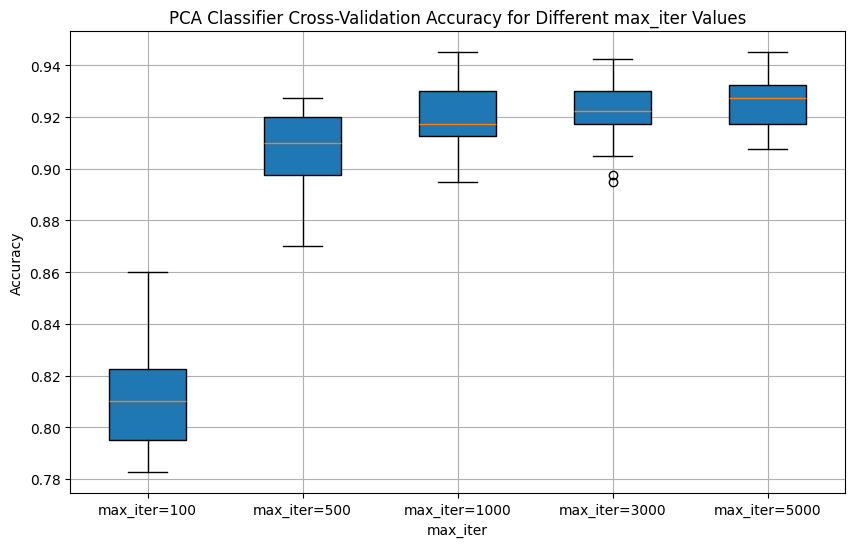


max_iter = 100, Sorted Accuracy Scores (25 values):
[0.7825, 0.785, 0.7875, 0.7875, 0.7925, 0.7925, 0.795, 0.7975, 0.7975, 0.8025, 0.8025, 0.805, 0.81, 0.81, 0.81, 0.8125, 0.815, 0.8225, 0.8225, 0.825, 0.8275, 0.83, 0.83, 0.83, 0.86]

max_iter = 500, Sorted Accuracy Scores (25 values):
[0.87, 0.8725, 0.8825, 0.89, 0.8925, 0.895, 0.8975, 0.9, 0.9, 0.9025, 0.905, 0.905, 0.91, 0.91, 0.9125, 0.915, 0.915, 0.9175, 0.92, 0.92, 0.92, 0.925, 0.925, 0.925, 0.9275]

max_iter = 1000, Sorted Accuracy Scores (25 values):
[0.895, 0.8975, 0.9025, 0.905, 0.9075, 0.9075, 0.9125, 0.9125, 0.9125, 0.9125, 0.915, 0.915, 0.9175, 0.9175, 0.92, 0.925, 0.9275, 0.93, 0.93, 0.93, 0.935, 0.935, 0.94, 0.945, 0.945]

max_iter = 3000, Sorted Accuracy Scores (25 values):
[0.895, 0.8975, 0.905, 0.91, 0.91, 0.915, 0.9175, 0.9175, 0.9175, 0.92, 0.92, 0.92, 0.9225, 0.9225, 0.9225, 0.925, 0.9275, 0.93, 0.93, 0.9325, 0.9325, 0.935, 0.935, 0.935, 0.9425]

max_iter = 5000, Sorted Accuracy Scores (25 values):
[0.9075, 0.91, 

In [60]:
#tune parameters for PCA classifier with cross-validation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# k values for cross-validation
max_iter_values = [100, 500, 1000, 3000, 5000]
repeats = 5
all_results = []

print("Starting cross-validation...\n")

for max_iter in max_iter_values:
    print(f"Testing max_iter = {max_iter}")
    scores_max_iter = []

    for rep in range(repeats):
        print(f"  Repeat {rep + 1}/{repeats}")
        
        # Cross-validation with PCA classifier
        scores = cross_validate(
            images=images,
            labels=labels,
            train_fn=lambda train_images, train_labels: train_PCA(train_images, train_labels, max_iter=max_iter),
            predict_fn=predict_with_PCA,
            k_folds=5,
            metric_fn=accuracy_score
        )
        scores_max_iter.extend(scores)

    all_results.append(scores_max_iter)

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(all_results, labels=[f"max_iter={mi}" for mi in max_iter_values], patch_artist=True)
plt.title("PCA Classifier Cross-Validation Accuracy for Different max_iter Values")
plt.ylabel("Accuracy")
plt.xlabel("max_iter")
plt.grid(True)
plt.show()

# Print sorted accuracy scores for each max_iter
for i, max_iter in enumerate(max_iter_values):
    sorted_scores = sorted(all_results[i])
    print(f"\nmax_iter = {max_iter}, Sorted Accuracy Scores ({len(sorted_scores)} values):")
    print(sorted_scores)


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Testing epochs = 1
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 56.34it/s, v_num=95]
    Accuracy: 0.1675  =>  Error: 0.8325
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 65.88it/s, v_num=96]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 65.78it/s, v_num=97]
    Accuracy: 0.1775  =>  Error: 0.8225
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 58.91it/s, v_num=98]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 67.32it/s, v_num=99]
    Accuracy: 0.2900  =>  Error: 0.7100
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 68.55it/s, v_num=100]
    Accuracy: 0.2500  =>  Error: 0.7500
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 67.93it/s, v_num=101]
    Accuracy: 0.2100  =>  Error: 0.7900
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 0: 100%|██████████| 50/50 [00:00<00:00, 75.28it/s, v_num=102]
    Accuracy: 0.1575  =>  Error: 0.8425
Testing epochs = 3
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 68.67it/s, v_num=103]
    Accuracy: 0.2825  =>  Error: 0.7175
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 67.44it/s, v_num=104]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 73.72it/s, v_num=105]
    Accuracy: 0.1775  =>  Error: 0.8225
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 69.15it/s, v_num=106]
    Accuracy: 0.2775  =>  Error: 0.7225
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 71.01it/s, v_num=107]
    Accuracy: 0.1900  =>  Error: 0.8100
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 67.02it/s, v_num=108]
    Accuracy: 0.2975  =>  Error: 0.7025
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 70.33it/s, v_num=109]
    Accuracy: 0.1500  =>  Error: 0.8500
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 63.86it/s, v_num=110]
    Accuracy: 0.1575  =>  Error: 0.8425
Testing epochs = 5
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 73.19it/s, v_num=111]
    Accuracy: 0.4950  =>  Error: 0.5050
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 64.52it/s, v_num=112]
    Accuracy: 0.2950  =>  Error: 0.7050
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 72.55it/s, v_num=113]
    Accuracy: 0.1775  =>  Error: 0.8225
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 61.67it/s, v_num=114]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 71.42it/s, v_num=115]
    Accuracy: 0.1750  =>  Error: 0.8250
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 71.93it/s, v_num=116]
    Accuracy: 0.1800  =>  Error: 0.8200
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 68.12it/s, v_num=117]
    Accuracy: 0.4925  =>  Error: 0.5075
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 4: 100%|██████████| 50/50 [00:00<00:00, 74.27it/s, v_num=118]
    Accuracy: 0.1575  =>  Error: 0.8425
Testing epochs = 7
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 60.09it/s, v_num=119]
    Accuracy: 0.5250  =>  Error: 0.4750
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 71.11it/s, v_num=120]
    Accuracy: 0.4325  =>  Error: 0.5675
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 71.31it/s, v_num=121]
    Accuracy: 0.6375  =>  Error: 0.3625
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 71.42it/s, v_num=122]
    Accuracy: 0.2175  =>  Error: 0.7825
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 62.12it/s, v_num=123]
    Accuracy: 0.4550  =>  Error: 0.5450
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 63.77it/s, v_num=124]
    Accuracy: 0.5900  =>  Error: 0.4100
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 62.82it/s, v_num=125]
    Accuracy: 0.5825  =>  Error: 0.4175
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 6: 100%|██████████| 50/50 [00:00<00:00, 67.07it/s, v_num=126]
    Accuracy: 0.6675  =>  Error: 0.3325
Testing epochs = 10
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 67.56it/s, v_num=127]
    Accuracy: 0.7575  =>  Error: 0.2425
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 70.51it/s, v_num=128]
    Accuracy: 0.3825  =>  Error: 0.6175
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 68.60it/s, v_num=129]
    Accuracy: 0.1775  =>  Error: 0.8225
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 73.16it/s, v_num=130]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 69.15it/s, v_num=131]
    Accuracy: 0.6400  =>  Error: 0.3600
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 61.89it/s, v_num=132]
    Accuracy: 0.5625  =>  Error: 0.4375
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 72.87it/s, v_num=133]
    Accuracy: 0.6325  =>  Error: 0.3675
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 9: 100%|██████████| 50/50 [00:00<00:00, 68.58it/s, v_num=134]
    Accuracy: 0.5450  =>  Error: 0.4550
Testing epochs = 15
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 74.16it/s, v_num=135]
    Accuracy: 0.1675  =>  Error: 0.8325
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 72.66it/s, v_num=136]
    Accuracy: 0.5600  =>  Error: 0.4400
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 73.51it/s, v_num=137]
    Accuracy: 0.4725  =>  Error: 0.5275
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 75.62it/s, v_num=138]
    Accuracy: 0.6700  =>  Error: 0.3300
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 55.95it/s, v_num=139]
    Accuracy: 0.1900  =>  Error: 0.8100
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 68.12it/s, v_num=140]
    Accuracy: 0.1800  =>  Error: 0.8200
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 70.31it/s, v_num=141]
    Accuracy: 0.8525  =>  Error: 0.1475
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 14: 100%|██████████| 50/50 [00:00<00:00, 68.21it/s, v_num=142]
    Accuracy: 0.6850  =>  Error: 0.3150
Testing epochs = 20
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 71.11it/s, v_num=143]
    Accuracy: 0.1675  =>  Error: 0.8325
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 64.69it/s, v_num=144]
    Accuracy: 0.8275  =>  Error: 0.1725
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 61.82it/s, v_num=145]
    Accuracy: 0.7700  =>  Error: 0.2300
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 61.74it/s, v_num=146]
    Accuracy: 0.6900  =>  Error: 0.3100
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 69.73it/s, v_num=147]
    Accuracy: 0.8450  =>  Error: 0.1550
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 72.34it/s, v_num=148]
    Accuracy: 0.8650  =>  Error: 0.1350
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 67.94it/s, v_num=149]
    Accuracy: 0.7175  =>  Error: 0.2825
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 19: 100%|██████████| 50/50 [00:00<00:00, 58.53it/s, v_num=150]
    Accuracy: 0.9000  =>  Error: 0.1000
Testing epochs = 30
  Repeat 1/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 68.17it/s, v_num=151]
    Accuracy: 0.8775  =>  Error: 0.1225
  Repeat 2/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 69.63it/s, v_num=152]
    Accuracy: 0.1650  =>  Error: 0.8350
  Repeat 3/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 61.42it/s, v_num=153]
    Accuracy: 0.9000  =>  Error: 0.1000
  Repeat 4/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 67.20it/s, v_num=154]
    Accuracy: 0.7775  =>  Error: 0.2225
  Repeat 5/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 61.74it/s, v_num=155]
    Accuracy: 0.8950  =>  Error: 0.1050
  Repeat 6/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 73.73it/s, v_num=156]
    Accuracy: 0.8825  =>  Error: 0.1175
  Repeat 7/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 73.40it/s, v_num=157]
    Accuracy: 0.1900  =>  Error: 0.8100
  Repeat 8/8


C:\Users\Nils\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | CrossEntropyLoss | 0      | eval 
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | Sequential       | 19.7 K | train
5 | loss_fn       | NLLLoss          | 0      | train
6 | optimizer     | RMSprop          | 0      | train
-----------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
30        Modules in train mode
1        

Epoch 29: 100%|██████████| 50/50 [00:00<00:00, 76.42it/s, v_num=158]
    Accuracy: 0.8450  =>  Error: 0.1550


C:\Users\Nils\AppData\Local\Temp\ipykernel_24980\1151967944.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors_by_epoch, labels=[str(e) for e in epoch_values], patch_artist=True)


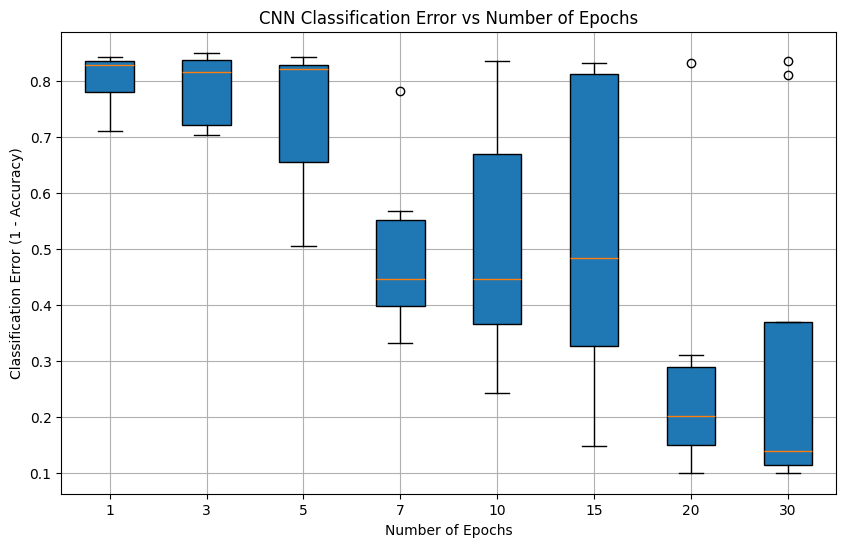


epochs = 1, Sorted Errors (8 values):
[0.71, 0.75, 0.79, 0.8225, 0.8325, 0.835, 0.835, 0.8425]

epochs = 3, Sorted Errors (8 values):
[0.7025, 0.7175, 0.7224999999999999, 0.81, 0.8225, 0.835, 0.8425, 0.85]

epochs = 5, Sorted Errors (8 values):
[0.505, 0.5075000000000001, 0.7050000000000001, 0.8200000000000001, 0.8225, 0.825, 0.835, 0.8425]

epochs = 7, Sorted Errors (8 values):
[0.3325, 0.36250000000000004, 0.41000000000000003, 0.4175, 0.475, 0.5449999999999999, 0.5675, 0.7825]

epochs = 10, Sorted Errors (8 values):
[0.24250000000000005, 0.36, 0.36750000000000005, 0.4375, 0.45499999999999996, 0.6174999999999999, 0.8225, 0.835]

epochs = 15, Sorted Errors (8 values):
[0.14749999999999996, 0.31499999999999995, 0.32999999999999996, 0.43999999999999995, 0.5275000000000001, 0.81, 0.8200000000000001, 0.8325]

epochs = 20, Sorted Errors (8 values):
[0.09999999999999998, 0.135, 0.15500000000000003, 0.1725, 0.22999999999999998, 0.2825, 0.31000000000000005, 0.8325]

epochs = 30, Sorted Errors

In [ ]:
#CV + tune CNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch

# Define the number of epochs to test
epoch_values = [1, 3, 5, 7, 10, 15, 20,30]
repeats = 8
errors_by_epoch = []

# Load data
images, labels = read_mnist_txt("Numbers.txt")

for epochs in epoch_values:
    print(f"Testing epochs = {epochs}")
    error_list = []

    for repeat in range(repeats):
        print(f"  Repeat {repeat + 1}/{repeats}")
        
        train_images, test_images, train_labels, test_labels = train_test_split(
            images, labels, test_size=0.2, random_state=42 + repeat  # slight variation in data
        )

        classifier = train_cnn(train_images, train_labels, lr=0.001, epochs=epochs)
        predictions = predict_with__cnn(classifier, test_images)
        
        acc = accuracy_score(test_labels, predictions)
        error = 1 - acc
        print(f"    Accuracy: {acc:.4f}  =>  Error: {error:.4f}")
        error_list.append(error)

    errors_by_epoch.append(error_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.boxplot(errors_by_epoch, labels=[str(e) for e in epoch_values], patch_artist=True)
plt.title("CNN Classification Error vs Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Classification Error (1 - Accuracy)")
plt.grid(True)
plt.show()

# Print sorted errors
for i, e in enumerate(epoch_values):
    sorted_errors = sorted(errors_by_epoch[i])
    print(f"\nepochs = {e}, Sorted Errors ({len(sorted_errors)} values):")
    print(sorted_errors)


In [2]:
cnn_mean_errors = [np.mean(errs) for errs in errors_by_epoch]

plt.figure(figsize=(8, 5))
plt.plot(epoch_values, cnn_mean_errors, marker='o', linestyle='-', color='blue')
plt.title("Mean Classification Error vs. Epochs (CNN)")
plt.xlabel("Number of Epochs")
plt.ylabel("Mean Classification Error")
plt.grid(True)
plt.show()


NameError: name 'errors_by_epoch' is not defined